<a href="https://colab.research.google.com/github/aerjayc/coe197z-hw1/blob/master/cifar_10_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we download the `CIFAR-10` dataset and extract its contents to the current directory. The working directory is now:


```
>ls
  cifar-10-batches-py  cifar-10-python.tar.gz  sample_data
>ls cifar-10-batches-py
  batches.meta  data_batch_2  data_batch_4  readme.html
  data_batch_1  data_batch_3  data_batch_5  test_batch
```



In [1]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2019-09-14 16:49:48--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.9MB/s    in 13s     

2019-09-14 16:50:03 (12.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Then, we "unpickle" the downloaded dataset. The `unpickle()` function was taken from the [CIFAR website](http://www.cs.toronto.edu/~kriz/cifar.html). It takes the filename of any of the batch files, and outputs the `dict` contained in that file.
The structure of these `dict`'s is the following:


```
batch = {
  b'batch_label': b'training batch 1 of 5',
  b'data': array([ [<image_0>],
                   ...,
                   [<image 9999>]
                 ], dtype=uint8),
  b'filenames': [b'<filename_0.png',
                 ...,
                 b'<filename_9999.png',
                ],
  b'labels': [<label_0>, ..., <label_9999>],
}
```

where:

*   `[<image i>]` is a numpy vector of shape `(1024*1024*3,)`. The first `1024` entries in the vector correspond to the pixel intensities of the red channel, the second `1024` corresponds to the blue channel, and so on. Note that the pixel intensity spans the entire uint8 values.
*   `b'<filename_i>'` is a binary string corresponding to the filename of the `i`-th image
*   `<label_i>` $\in \{0,1,...,9\}$, where each integer corresponds to some classification of the `i`-th image

Note that the dictionary keys are binary strings.

In [0]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
test_batch   = unpickle('cifar-10-batches-py/test_batch')
# x1 = data_batch_1[b'data']
# y1 = data_batch_1[b'labels']

In [0]:
import numpy as np

x = np.concatenate((data_batch_1[b'data'],
              data_batch_2[b'data'],
              data_batch_3[b'data'],
              data_batch_4[b'data']))
y = np.concatenate((data_batch_1[b'labels'],
              data_batch_2[b'labels'],
              data_batch_3[b'labels'],
              data_batch_4[b'labels']))

x_test = test_batch[b'data']
y_test = test_batch[b'labels']

https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

In [0]:
def split_train_set(data, labels, data_fraction=0.8):
  assert 0 < data_fraction <= 1

  # jointly shuffle the data and labels first
  # note: data and labels get shuffled (not copied)
  rng_state = np.random.get_state()
  np.random.shuffle(data)
  np.random.set_state(rng_state)
  np.random.shuffle(labels)

  # get the first data_fraction of the train set
  boundary = int(len(data)*data_fraction)
  train_data   = data[:boundary]
  train_labels = labels[:boundary]
  validation_data = data[boundary:]
  validation_labels = labels[boundary:]

  return (train_data, train_labels), (validation_data, validation_labels)

(x_train, y_train), (x_val, y_val) = split_train_set(x, y)

# normalization, vectorization
from keras.utils import to_categorical
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)
x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [30]:
from keras import models
from keras import layers

# input parameters
input_shape = x_train[0].shape
num_labels = 10

# network parameters
batch_size = 64
hidden_units = 128
data_augmentation = False
epochs = 50
max_batches = len(x_train) // batch_size

model = models.Sequential()
model.add(layers.Dense(hidden_units, activation='relu', 
                       input_shape=input_shape))
model.add(layers.Dense(hidden_units, activation='relu'))
model.add(layers.Dense(num_labels, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [31]:
# training the model
history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val))

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 2s 70us/step - loss: 2.0468 - acc: 0.2654 - val_loss: 1.8892 - val_acc: 0.3294
Epoch 2/50
32000/32000 [==============================] - 2s 64us/step - loss: 1.8079 - acc: 0.3477 - val_loss: 1.7308 - val_acc: 0.3755
Epoch 3/50
32000/32000 [==============================] - 2s 64us/step - loss: 1.7256 - acc: 0.3822 - val_loss: 1.6864 - val_acc: 0.3960
Epoch 4/50
32000/32000 [==============================] - 2s 64us/step - loss: 1.6674 - acc: 0.4028 - val_loss: 1.6787 - val_acc: 0.3949
Epoch 5/50
32000/32000 [==============================] - 2s 61us/step - loss: 1.6297 - acc: 0.4168 - val_loss: 1.6457 - val_acc: 0.4093
Epoch 6/50
32000/32000 [==============================] - 2s 60us/step - loss: 1.5932 - acc: 0.4289 - val_loss: 1.6772 - val_acc: 0.3924
Epoch 7/50
32000/32000 [==============================] - 2s 62us/step - loss: 1.5658 - acc: 0.4413 - val_loss: 1.6406 - val_acc:

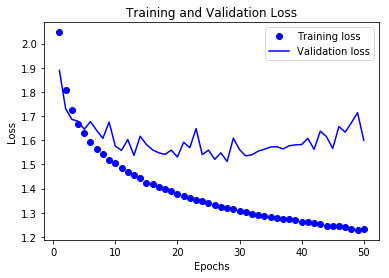

In [32]:
plot_loss(history)

In [0]:
# plotting the training and validation losses
import matplotlib.pyplot as plt

def plot_loss(history):
  # assert 'val_loss' in history.history

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epoch_axis = range(1, epochs + 1)

  plt.plot(epoch_axis, loss, 'bo', label='Training loss')
  plt.plot(epoch_axis, val_loss, 'b', label='Validation loss')

  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [0]:
# plotting the training and validation accuracy
def plot_acc(history):
  # assert 'val_acc' in history.history
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  plt.plot(epochs, acc, 'ro', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')

  plt.title('Training and validation loss & acc')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()

  plt.show()